## Machine Learning and Computational Statistics

### Name: Thomas Saltos

In [1]:
import scipy.io as sio
import numpy as np
import scipy.optimize 
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.optimize import nnls
from sklearn.linear_model import Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
# Bayesian
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

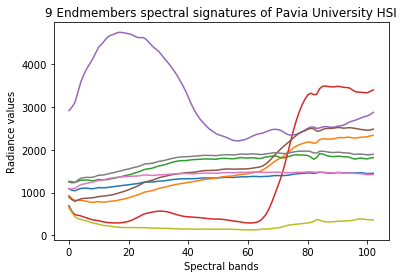

In [2]:
Pavia = sio.loadmat('PaviaU_cube.mat')
HSI = Pavia['X'] #Pavia HSI : 300x200x103

ends = sio.loadmat('PaviaU_endmembers.mat') # Endmember's matrix: 103x9
endmembers = ends['endmembers']
fig = plt.figure()
plt.plot(endmembers)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('9 Endmembers spectral signatures of Pavia University HSI')
plt.show()

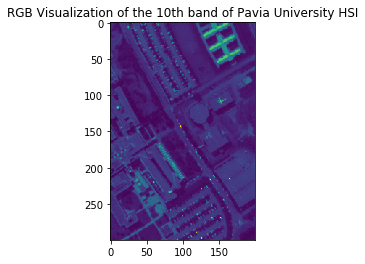

In [3]:
#Perform unmixing for the pixels corresponding to nonzero labels
ground_truth= sio.loadmat('PaviaU_ground_truth.mat')
labels=ground_truth['y']

fig = plt.figure()
plt.imshow(HSI[:,:,10])
plt.title('RGB Visualization of the 10th band of Pavia University HSI')
plt.show()
# For the non-negative least squares  unmixing algorithm  you can use the nnls function, see the following link:
#https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.nnls.html#scipy.optimize.nnls
# ..............
#
#..................

In [4]:
M = HSI.shape[0]
N = HSI.shape[1]
L = HSI.shape[2]
no_pixels = M*N

HSI_reshaped = HSI.reshape((no_pixels,L))

for i in range(no_pixels):
    for j in range(L):
        if HSI_reshaped[i,j]<0:
            HSI_reshaped[i,j]=0

In [5]:
ground_truth_reshaped = labels.reshape((no_pixels,1))
len(ground_truth_reshaped)

60000

In [6]:
endmembers_names = ["Water","Trees","Asphalt","Self-Blocking Bricks","Bitumen","Tiles","Shadows","Meadows","Bare Soil"]

In [7]:
def plot_abundance_maps(a_map):
    """
    A function to Plot the Abundance Maps of the 9 EndMembers
    """
    fig, axs = plt.subplots(3, 3, figsize=(10, 10), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace=0.3, wspace=0.2)
    fig.suptitle('Abundance Maps') 
    axs = axs.ravel()
    for i in range(9):
        axs[i].imshow(a_map[:,i].reshape((300,200)))
        axs[i].set_title('Endmember {}'.format(endmembers_names[i]))
    plt.show()
    plt.close()
    return

In [8]:
def reconstruction_error(y_true, y_pred, mask, normalized=True):
    """
    A function to calculate the MSE of the reconstruction error
    """
    assert y_true.shape[0] == y_pred.shape[0]
    assert y_pred.shape[0] == mask.shape[0]
    
    reconstruction_error = 0
    eligible_pixels = 0 
    for i in range(y_true.shape[0]):
        if mask[i] > 0:
            error = np.linalg.norm(y_true[i,:] - y_pred[i,:])**2
            if normalized:
                error /= np.linalg.norm(y_true[i,:])**2
            reconstruction_error += error
            eligible_pixels +=1
    mean_reconstruction_error =  reconstruction_error / eligible_pixels
    return mean_reconstruction_error

## Part 1: Spectral Unmixing

## (A)

### a) Least squares method

In [9]:
M = HSI.shape[0]
N = HSI.shape[1]
no_pixels = M*N

X = endmembers 
theta_est_matrix = np.zeros((no_pixels,9))

for i in range(no_pixels):
    if ground_truth_reshaped[i]==0:
        continue
    else:
        y = HSI_reshaped[i,:]
        XTX_inv = np.linalg.inv(np.dot(X.T,X))
        theta_est = (XTX_inv).dot(X.T).dot(y.T)
        theta_est_matrix[i] = theta_est

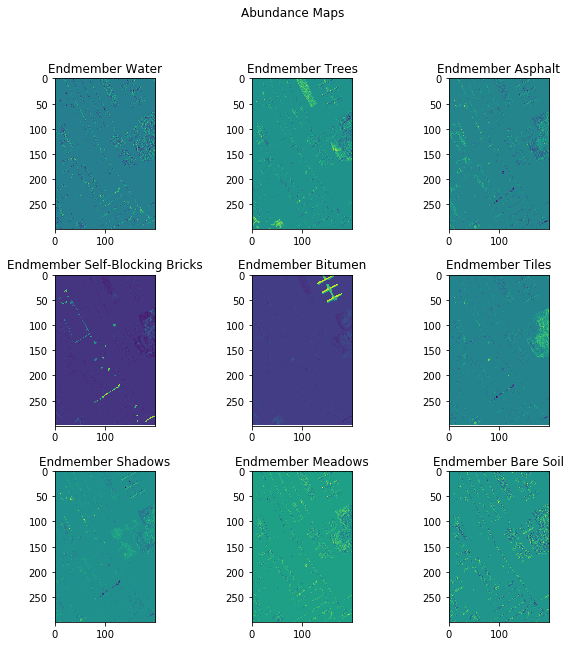

In [10]:
plot_abundance_maps(theta_est_matrix)

In [11]:
y = HSI_reshaped
y_est = X.dot(theta_est_matrix.T).transpose()

print('The normalized reconstruction error is ', reconstruction_error(y, y_est, mask=ground_truth_reshaped))

The normalized reconstruction error is  0.0014528012621974951


### b) Least squares imposing the sum-to-one constrain

In [12]:
M = HSI.shape[0]
N = HSI.shape[1]
no_pixels = M*N

X = endmembers 
theta_est_matrix2 = np.zeros((no_pixels,9))

#Using nnls to get initial guess
y = HSI_reshaped[i,:]
x0, rnorm = nnls(X, y)

#Define minimisation function
def min_func(x, A, b):
    return np.linalg.norm(A.dot(x) - b)

#Define constraints
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x)-1})
    
for i in range(no_pixels):
    if ground_truth_reshaped[i]==0:
        continue
    else:
        y = HSI_reshaped[i,:]
        minout = minimize(min_func, x0, args = (X,y), method = 'SLSQP', constraints = cons)
        x = minout.x
        theta_est_matrix2[i] = x

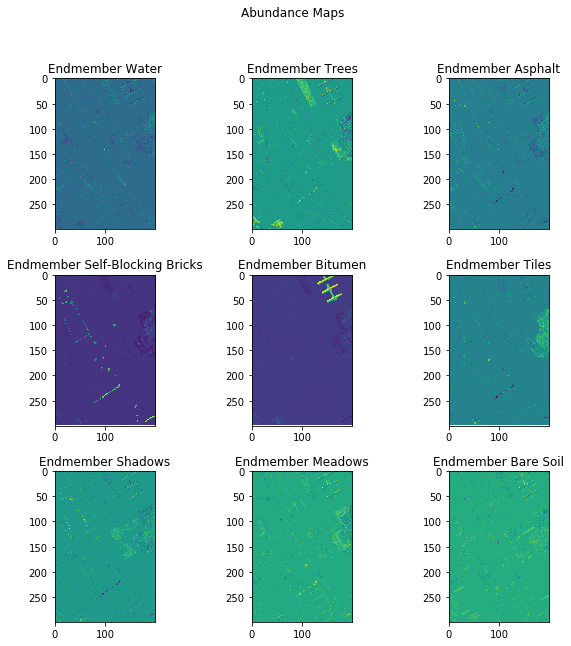

In [13]:
plot_abundance_maps(theta_est_matrix2)

In [14]:
y = HSI_reshaped
y_est2 = X.dot(theta_est_matrix2.T).transpose()

print('The normalized reconstruction error is ', reconstruction_error(y, y_est2, mask=ground_truth_reshaped))

The normalized reconstruction error is  0.0019650986378512043


### c) Least squares imposing the non-negativity constraint on the entries of θ

In [15]:
M = HSI.shape[0]
N = HSI.shape[1]
no_pixels = M*N

X = endmembers 
theta_est_matrix3 = np.zeros((no_pixels,9))

for i in range(no_pixels):
    if ground_truth_reshaped[i]==0:
        continue
    else:
        y = HSI_reshaped[i,:]
        x, rnorm = nnls(X, y)
        theta_est_matrix3[i] = x

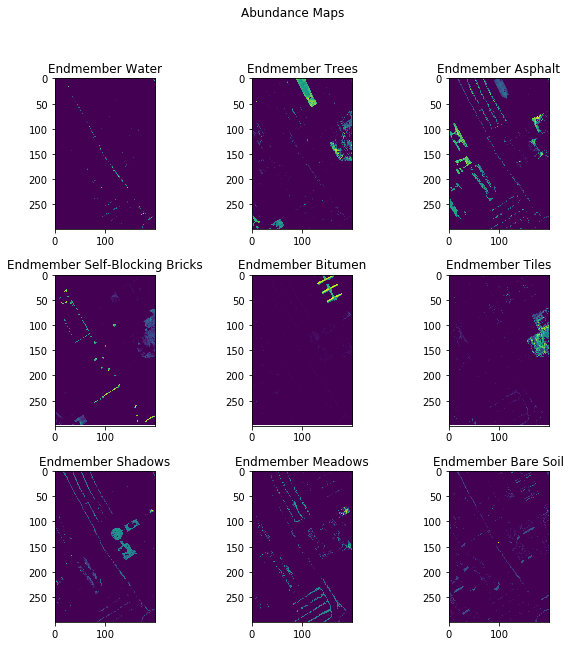

In [16]:
plot_abundance_maps(theta_est_matrix3)

In [17]:
y = HSI_reshaped
y_est3 = X.dot(theta_est_matrix3.T).transpose()

print('The normalized reconstruction error is ', reconstruction_error(y, y_est3, mask=ground_truth_reshaped))

The normalized reconstruction error is  0.0041859773385382664


### d) Least squares imposing both the non-negativity and the sum-to-one constraint on the entries of θ

In [18]:
M = HSI.shape[0]
N = HSI.shape[1]
no_pixels = M*N

X = endmembers 
theta_est_matrix4 = np.zeros((no_pixels,9))

#Using nnls to get initial guess
y = HSI_reshaped[i,:]
x0, rnorm = nnls(X, y)

#Define minimisation function
def min_func(x, A, b):
    return np.linalg.norm(A.dot(x) - b)

#Define constraints and bounds
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x)-1})
bnds = [(0., None) for x in x0]
    
for i in range(no_pixels):
    if ground_truth_reshaped[i]==0:
        continue
    else:
        y = HSI_reshaped[i,:]
        minout = minimize(min_func, x0, args = (X,y), method = 'SLSQP', constraints = cons, bounds = bnds)
        x = minout.x
        theta_est_matrix4[i] = x

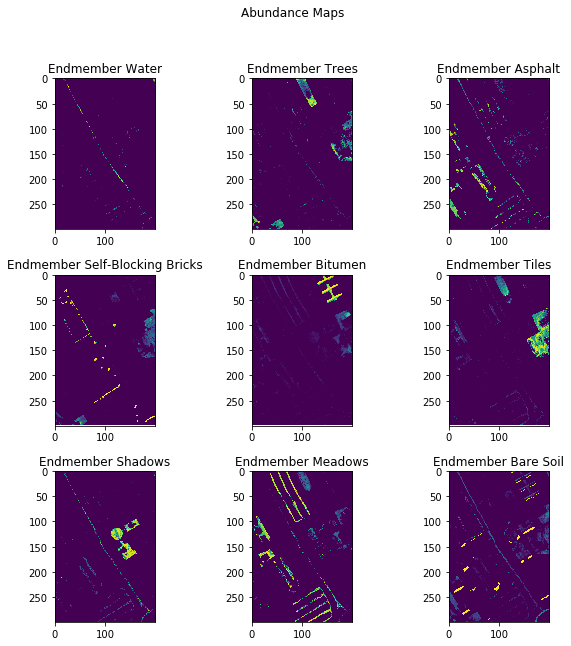

In [19]:
plot_abundance_maps(theta_est_matrix4)

In [20]:
y = HSI_reshaped
y_est4 = X.dot(theta_est_matrix4.T).transpose()

print('The normalized reconstruction error is ', reconstruction_error(y, y_est4, mask=ground_truth_reshaped))

The normalized reconstruction error is  0.012582037736274698


### e) LASSO

In [21]:
M = HSI.shape[0]
N = HSI.shape[1]
no_pixels = M*N

X = endmembers 
theta_est_matrix5 = np.zeros((no_pixels,9))

for i in range(no_pixels):
    if ground_truth_reshaped[i]==0:
        continue
    else:
        y = HSI_reshaped[i,:]   
        clf = Lasso(alpha = 0.1, positive =True, fit_intercept=False, max_iter = 1e7)
        clf.fit(X,y)
        theta_est_matrix5[i] = clf.coef_

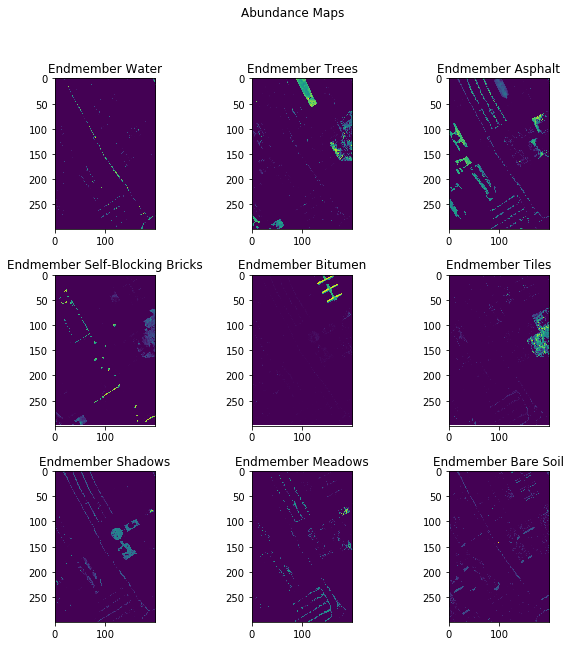

In [22]:
plot_abundance_maps(theta_est_matrix5)

In [23]:
y = HSI_reshaped
y_est5 = X.dot(theta_est_matrix5.T).transpose()

print('The normalized reconstruction error is ', reconstruction_error(y, y_est5, mask=ground_truth_reshaped))

The normalized reconstruction error is  0.004190177101073541


### (B) Comparison of the spectral unmixing results

- Abundance Maps:
    * Row 1 corresponds to the LS method
    * Row 2 corresponds to the LS method with sum-to-one constraint
    * Row 3 corresponds to the LS method with non-negativity constraint
    * Row 4 corresponds to the LS method with both sum-to-one and non-negativity constraints
    * Row 5 corresponds to the LASSO method

In [24]:
abundance_maps = [theta_est_matrix, theta_est_matrix2, theta_est_matrix3, theta_est_matrix4, theta_est_matrix5]

In [25]:
def compare_abundance_maps(a_map_array):
    """
    A function to Plot the per-Method Abundance Maps of the 9 EndMembers
    """
    fig, axs = plt.subplots(5, 9, figsize=(20, 20), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace=0.3, wspace=0.4)
    axs = axs.ravel()
    for a_idx, a_map in enumerate(a_map_array):
        for i in range(9):
            axs[a_idx*9 + i].imshow(a_map[:,i].reshape((300,200)))
            axs[a_idx*9 + i].set_title('{}'.format(endmembers_names[i]))
    plt.show()
    plt.close()
    return

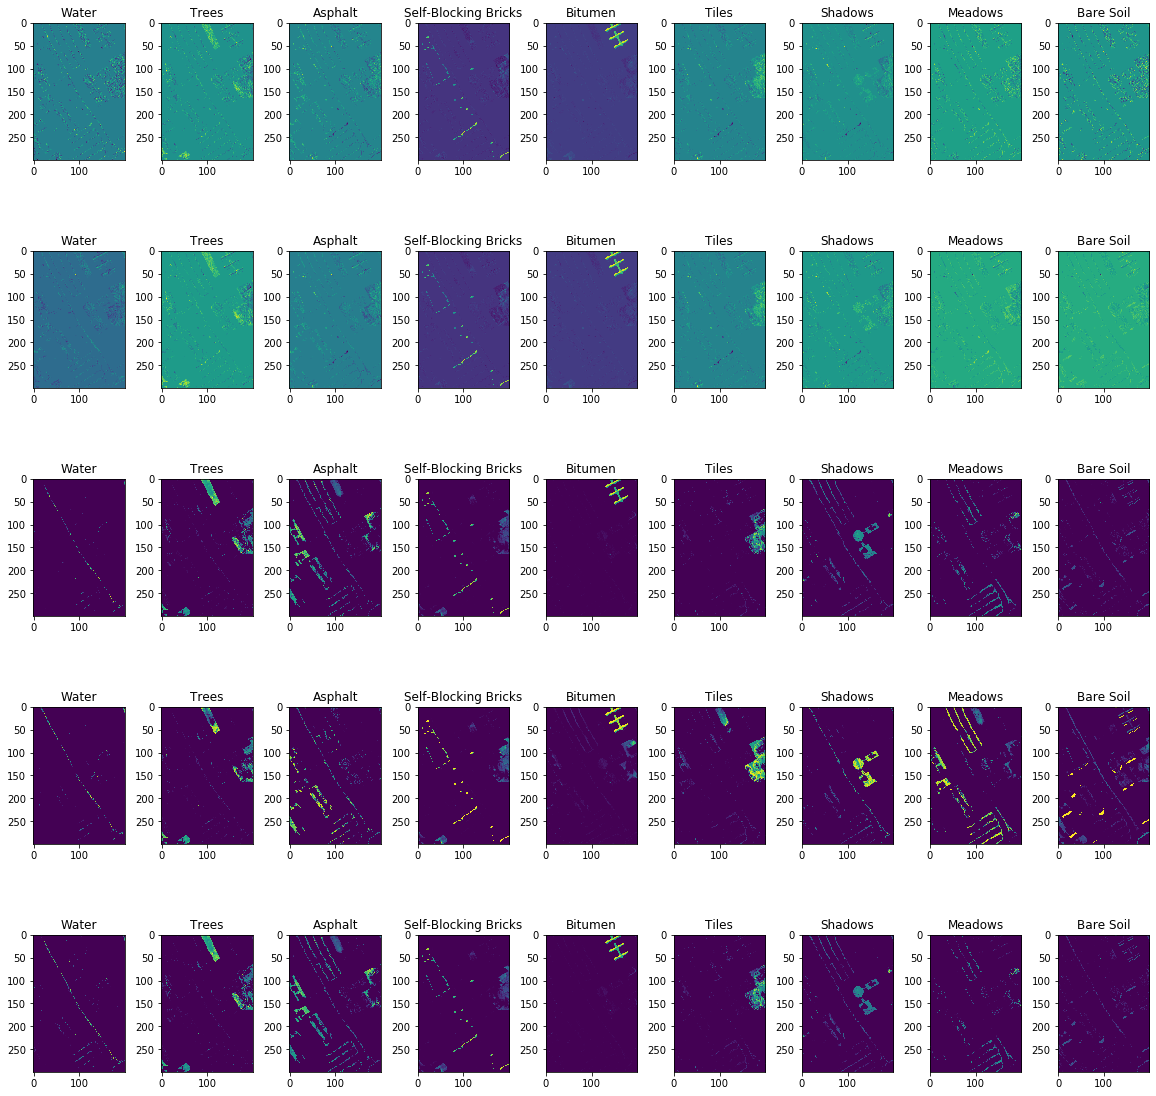

In [26]:
compare_abundance_maps(abundance_maps)

### The true class labels of the pixels of the Pavia University are depicted below

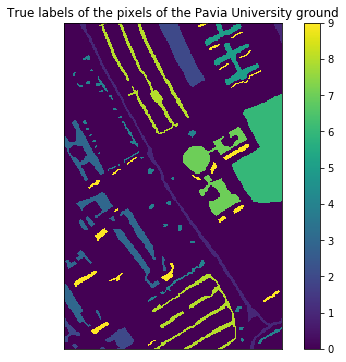

In [31]:
fig = plt.figure(figsize = (8,6))
plt.imshow(labels)
plt.title('True labels of the pixels of the Pavia University ground')
plt.colorbar()
plt.xticks(())
plt.yticks(())
plt.show()

From the above picture is can be assumed that the endmember correspondance to class is: 
$$endmember1 - Water \to class 2$$
$$endmember2 - Trees \to class 3$$
$$endmember3 - Apshalt \to class 4$$
$$endmember4 - Self Blocking Bricks \to class5$$
$$endmember5 - Bitumen \to class 6$$
$$endmember6 - Tiles \to class 7$$
$$endmember7 - Shadows \to class 8$$
$$endmember8 - Meadows \to class 9$$
$$endmember9 - Bare Soil \to class 1$$

The reconstruction errors for all methods are:

In [32]:
print('The reconstruction error of LS is: {}'.format(round(reconstruction_error(y, y_est, mask=ground_truth_reshaped),5)))
print('The reconstruction error of LS with sum-to-one constraint is: {}'.format(round(reconstruction_error(y, y_est2, mask=ground_truth_reshaped),5)))
print('The reconstruction error of LS with non-negativity constraint is: {}'.format(round(reconstruction_error(y, y_est3, mask=ground_truth_reshaped),5)))
print('The reconstruction error of LS with both sum-to-one and non-negativity constraints is: {}'.format(round(reconstruction_error(y, y_est4, mask=ground_truth_reshaped),5)))
print('The reconstruction error of LASSO is: {}'.format(round(reconstruction_error(y, y_est5, mask=ground_truth_reshaped),5)))

The reconstruction error of LS is: 0.00145
The reconstruction error of LS with sum-to-one constraint is: 0.00197
The reconstruction error of LS with non-negativity constraint is: 0.00419
The reconstruction error of LS with both sum-to-one and non-negativity constraints is: 0.01258
The reconstruction error of LASSO is: 0.00419


## Part 2: Classification

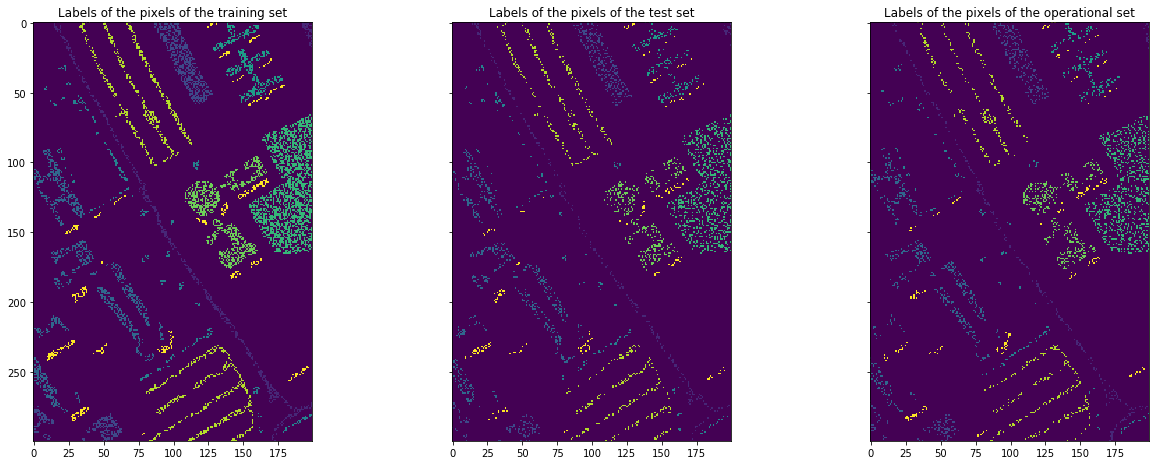

In [82]:
Pavia_labels = sio.loadmat('classification_labels_Pavia.mat')

# Trainining set for classification
Training_Set = Pavia_labels['training_set']
Training_img = (np.reshape(Pavia_labels['training_set'],(200,300))).T

# Test set for classification 
Test_Set = Pavia_labels['test_set']
Test_img = (np.reshape(Pavia_labels['test_set'],(200,300))).T

# Operational set for classification
Operational_Set = Pavia_labels['operational_set']
Operational_img = (np.reshape(Pavia_labels['operational_set'],(200,300))).T


# Creates two subplots and unpacks the output array immediately
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(20,20))
plt.subplots_adjust(wspace = 0.5)
ax1.imshow(Training_img)
ax1.set_title('Labels of the pixels of the training set')
ax2.imshow(Test_img)
ax2.set_title('Labels of the pixels of the test set')
ax3.imshow(Operational_img)
ax3.set_title('Labels of the pixels of the operational set')
plt.show()

In [83]:
def create_dataset(original_reshaped_image, flag):
    """
    A function that can convert the Labels to a (X,Y) Dataset.
    """
    X = np.empty((0,103))
    y = np.empty((0,1))
    
    ## Iterate over the non-zero pixels denoted by the flag
    for i in range(original_reshaped_image.shape[0]):
        if flag[i] != 0:
            X = np.append(X, [original_reshaped_image[i,:]], axis = 0) 
            y = np.append(y, [flag[i]], axis = 0)
            
    return X,y

In [84]:
### Training Set
X_train, y_train = create_dataset(HSI_reshaped, Training_Set)

### Testing Set
X_test, y_test = create_dataset(HSI_reshaped, Test_Set)

### Operational Set
X_operational, y_operational = create_dataset(HSI_reshaped, Operational_Set)

The success rate of a classifier is defined as the summation of the diagonal elements of the confusion matrix divided by the total number of elements of the matrix, N:
$$SR = \frac{1}{N}\sum_{i=1}^{M}A_{ii}$$

In [85]:
def success_rate(x):  
    success_rate = np.trace(x) / np.sum(x)
    return success_rate

### Naive Bayes Classifier

The naive Bayes classifer is trained based on the training data set performing 10-fold cross validation.

In [86]:
Bayes_Score = cross_val_score(GaussianNB(), X_train, y_train.ravel(), cv=10)
print("Naive Bayes Accuracy: %0.2f (+/- %0.2f)" % (Bayes_Score.mean(), Bayes_Score.std() * 2))

Bayes_Error = 1-Bayes_Score
print("Naive Bayes Error Mean %0.2f" % Bayes_Error.mean())
print("Naive Bayes Error Std %0.2f" % Bayes_Error.std())

Naive Bayes Accuracy: 0.11 (+/- 0.05)
Naive Bayes Error Mean 0.89
Naive Bayes Error Std 0.02


In the second approach, the naive Bayes classifer is trained using the training data set and performance evaluation is performed based on the test data set.

In [87]:
model = GaussianNB()
model.fit(X_train, y_train.ravel())

pred = model.predict(X_test)

cm = confusion_matrix(y_test, pred)
print("Confusion matrix:\n%s" % cm)

Confusion matrix:
[[ 16 119  29   0  43  27   0   0  27]
 [ 21 184  23   0  65  26   0   0  34]
 [ 28 241  65   0  91  55   1   0  55]
 [  5  67  16   0  39  10   2   0  17]
 [ 10  50  26   0  49   9   1   0  23]
 [ 34 319  59   0 157  81   1   1 112]
 [  9 179  25   0  64  15   3   0  26]
 [ 32 245  14   0  95  32   1   0  42]
 [  9  80  17   0  51  16   0   0  14]]


In [88]:
print('The success rate of naive Bayes classifier is ', round(success_rate(cm),3))

The success rate of naive Bayes classifier is  0.128


### Minimum Eucledian Distance Classifier

Bellow is an implementation of Minimum Eucledian Distance Classifier

In [89]:
class MEucledianDC:
    
    def __init__(self, n_classes=9):
        self.n_classes = n_classes
        self.is_fit_ = False
        self.class_means = np.empty((n_classes,103))
        return
    
    def fit(self, X, y):
        y = y.ravel()
        ### For every possible class
        for class_id in range(1, self.n_classes+1):
            x_slice = X[np.where(y==class_id)]
            class_mean = np.mean(x_slice, axis=0)
            self.class_means[class_id-1] = class_mean
            
        self.is_fit_ = True
        return
    
    def transform(self, X):
        if self.is_fit_:
            total_X = X
            results = np.empty(total_X.shape[0])
            for i, X in enumerate(total_X):
                canditate_class = 0
                canditate_dist = 1e10

                for idx, class_mean in enumerate(self.class_means):
                    dist_from_class = np.min(np.linalg.norm(X - class_mean)**2)
                    if dist_from_class < canditate_dist:
                        canditate_dist = dist_from_class
                        canditate_class = idx + 1
                results[i] = canditate_class
            return results
        else:
            print('Fit Estimator First!\n')

In [90]:
kfold = KFold(n_splits=10)
medc_score = np.empty(10)
index = 0
for train_index, test_index in kfold.split(X_train, y_train):
    clf = MEucledianDC()
    X_train_cv = X_train[train_index]
    y_train_cv = y_train[train_index]
    X_test_cv = X_train[test_index]
    y_test_cv = y_train[test_index]
    clf.fit(X_train_cv, y_train_cv)
    y_predicted = clf.transform(X_test_cv)
    pseudo_matrix = confusion_matrix(y_test_cv, y_predicted)
    medc_score[index] = success_rate(pseudo_matrix)
    index += 1

In [91]:
print("Min Eucledian Distance Classifier Accuracy: %0.2f (+/- %0.2f)" % (medc_score.mean(), medc_score.std() * 2))

medc_error = 1-medc_score
print("Min Eucledian Distance Classifier Error Mean %0.2f" % medc_error.mean())
print("Min Eucledian Distance Classifier Error Std %0.2f" % medc_error.std())

Min Eucledian Distance Classifier Accuracy: 0.12 (+/- 0.11)
Min Eucledian Distance Classifier Error Mean 0.88
Min Eucledian Distance Classifier Error Std 0.06


In the second approach, the min Euclidean distance classifier is trained using the training data set and performance evaluation is performed based on the test data set.

In [92]:
clf = MEucledianDC()
clf.fit(X_train,y_train)
y_predicted = clf.transform(X_test)
cm = confusion_matrix(y_test, y_predicted)

In [93]:
print("Confusion matrix:\n%s" % cm)

Confusion matrix:
[[ 47  25  49   0  79  13  42   3   3]
 [ 63  38  52   0 116   8  73   1   2]
 [132  52 116   0 158  21  52   2   3]
 [ 26  18  23   0  59   8  20   0   2]
 [ 17   7  34   1  67  11  29   0   2]
 [108  84  95   0 331  38  95   4   9]
 [ 32  57  57   0  98   3  69   0   5]
 [136  47  44   0 153  23  52   2   4]
 [ 35  16  30   0  70   2  31   3   0]]


In [94]:
print('The success rate of Minimum Eucledian Distance Classifier ', round(success_rate(cm),3))

The success rate of Minimum Eucledian Distance Classifier  0.118


### k-Nearest Neighbor Classifier

The k-NN classifer (k=9) is trained based on the training data set performing 10-fold cross validation.

In [106]:
kfold=10
## We choose n_neighbors equal to the number of classes we have
n_neighbors = 9
knc_score = cross_val_score(KNeighborsClassifier(n_neighbors=n_neighbors), X_train, y_train.ravel(), cv=kfold)

In [107]:
print("k-Nearest Neighbor Classifier Accuracy: %0.2f (+/- %0.2f)" % (knc_score.mean(), knc_score.std() * 2))

knc_error = 1-knc_score
print("k-Nearest Neighbor Classifier Error Mean %0.2f" % knc_error.mean())
print("k-Nearest Neighbor Classifier Error Std %0.2f" % knc_error.std())

k-Nearest Neighbor Classifier Accuracy: 0.26 (+/- 0.06)
k-Nearest Neighbor Classifier Error Mean 0.74
k-Nearest Neighbor Classifier Error Std 0.03


In the second approach, the k-NN classifer (k=9) is trained using the training data set and performance evaluation is performed based on the test data set.

In [108]:
clf = KNeighborsClassifier(n_neighbors=9)
clf.fit(X_train, y_train.ravel())

y_predicted = clf.predict(X_test)

cm = confusion_matrix(y_test, y_predicted)
print("Confusion matrix:\n%s" % cm)

Confusion matrix:
[[ 56  27  41   5   8  75  16  31   2]
 [ 34 124  57   5  10  72  20  28   3]
 [ 56  67 223   2  10 116  14  42   6]
 [ 14  21  37   1   2  44  11  26   0]
 [ 25  16  23   3  11  65  10  13   2]
 [ 78  51  96   8  24 424  36  40   7]
 [ 23  54  45   5  12  76  65  37   4]
 [ 39  68  82  13  10 116  37  93   3]
 [ 18  19  42   3   3  68  19  12   3]]


In [109]:
print('The success rate of k-NN classifier is ', round(success_rate(cm),3))

The success rate of k-NN classifier is  0.312


### Bayesian Classifier

The Bayesian classifer is trained based on the training data set performing 10-fold cross validation.

In [100]:
Bayesian_Score = cross_val_score(QuadraticDiscriminantAnalysis(), X_train, y_train.ravel(), cv=10)
print("Bayes Accuracy: %0.2f (+/- %0.2f)" % (Bayesian_Score.mean(), Bayesian_Score.std() * 2))

Bayesian_Error = 1-Bayesian_Score
print("Bayes Error Mean %0.2f" % Bayesian_Error.mean())
print("Bayes Error Std %0.2f" % Bayesian_Error.std())

Bayes Accuracy: 0.21 (+/- 0.02)
Bayes Error Mean 0.79
Bayes Error Std 0.01


In the second approach, the Bayesian classifer is trained using the training data set and performance evaluation is performed based on the test data set.

In [101]:
model = QuadraticDiscriminantAnalysis()
model.fit(X_train, y_train.ravel())

pred = model.predict(X_test)

cm = confusion_matrix(y_test, pred)
print("Confusion matrix:\n%s" % cm)

Confusion matrix:
[[ 26  41  51   3   2  95  21  17   5]
 [ 27  69  44   3   3 138  39  24   6]
 [ 40  82 147   3   8 154  52  36  14]
 [  8  18  44   2   0  57  14  11   2]
 [ 11  24  20   0   6  65  30  10   2]
 [ 66 123  73   8  10 352  82  30  20]
 [ 20  47  36   5  11 104  50  37  11]
 [ 38  81  60   4   5 162  46  51  14]
 [ 17  29  29   1   8  69  18  11   5]]


In [102]:
print('The success rate of Bayesian classifier is ', round(success_rate(cm),3))

The success rate of Bayesian classifier is  0.221


## Part 3: Combination of results

From spectral unmixing we get the abundance maps of the endmembers present in the image. In each abundance map the percentage of contribution of a spesific endmember is given for each pixel. On the other hand classification assigns each pixel to a specific class. The endmember correspondance to class is:
$$endmember1 - Water \to class 2$$
$$endmember2 - Trees \to class 3$$
$$endmember3 - Apshalt \to class 4$$
$$endmember4 - Self Blocking Bricks \to class5$$
$$endmember5 - Bitumen \to class 6$$
$$endmember6 - Tiles \to class 7$$
$$endmember7 - Shadows \to class 8$$
$$endmember8 - Meadows \to class 9$$
$$endmember9 - Bare Soil \to class 1$$

Thus for each pixel, the endmember with maximun percentage of contribution (among the 9 endmembers) found by spectral unmixing should correspond to the respective class to which the pixel is assigned by classification. This holds under the assumption that the results obtained by spectral unmixing and classification are correct.